In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

Local_path='/home/jmdeloui/STL_dev/STL_main'
sys.path.append(Local_path)

from STL_Healpix_Kernel_Torch import STL_Healpix_Kernel_Torch as DataClass
from ST_Operator import ST_Operator as SO
from Synthesis import optimize_scattering_LBFGS

In [2]:
nside=32

im=np.random.rand(12*nside**2)
data=DataClass(im)

# test wavelet computation

/home/jmdeloui/miniconda3/envs/py311/lib/python3.11/site-packages/healpy/projector.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  img[w] = mpix


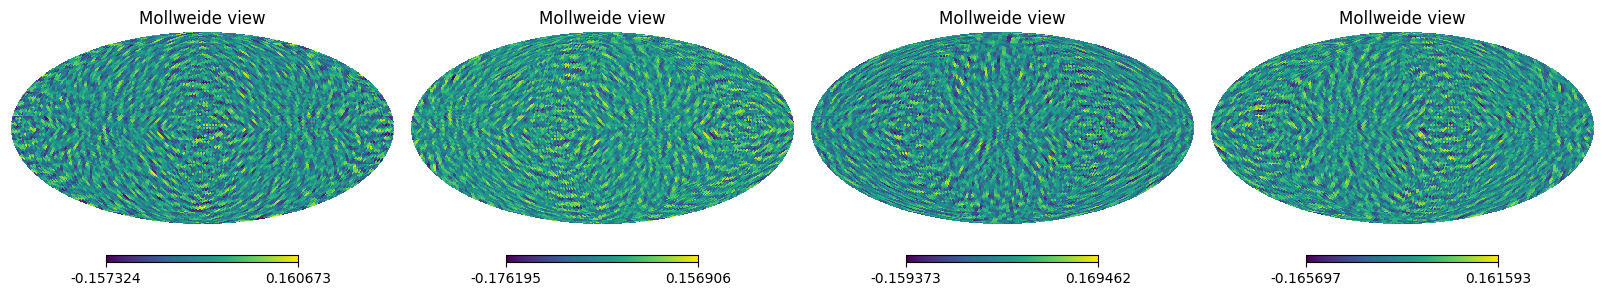

In [3]:
w_op=data.get_wavelet_op()

w_data = w_op.apply(data,0).array

plt.figure(figsize=(16,6))
for k in range(4):
    hp.mollview(w_data[k].cpu().numpy(),nest=True,hold=False,sub=(1,4,1+k))

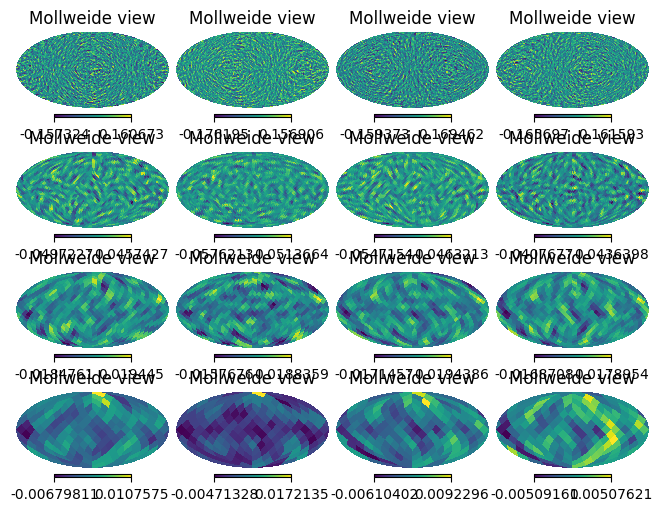

In [4]:
l_data=DataClass(im)
for j in range(4):
    w_data = w_op.apply(l_data,j).array
    for k in range(4):
        hp.mollview(w_data[k].cpu().numpy(),nest=True,hold=False,sub=(4,4,1+k+4*j))
    
    #l_data=w_op.apply_smooth(l_data,copy=True)
    l_data=l_data.downsample(j+1)

In [5]:
from ST_Operator import ST_Operator as STO

l_data=DataClass(im)

st_op=STO(l_data)

st_data = st_op.apply(l_data)

st_data.plot_coeff()

# do synthesis

In [6]:
st_data = st_op.apply(l_data)
st_data_norm = st_op.apply(l_data,norm='store_ref')

/home/jmdeloui/miniconda3/envs/py311/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/jmdeloui/miniconda3/envs/py311/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


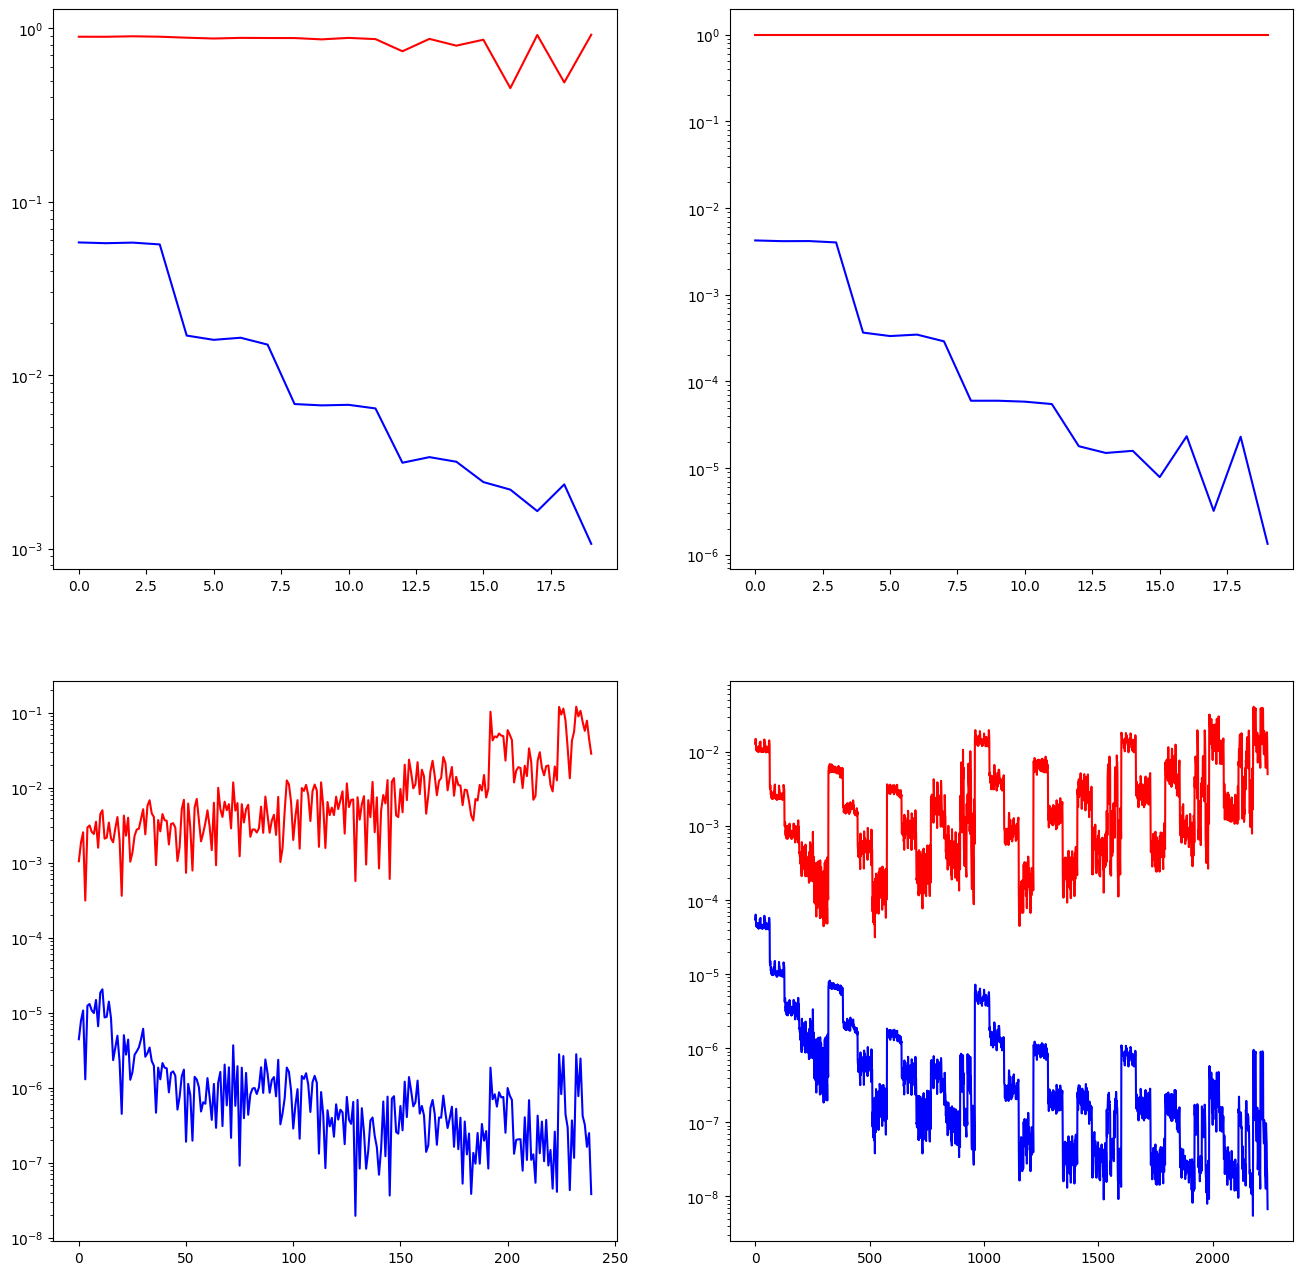

In [7]:
plt.figure(figsize=(16,16))
plt.subplot(2,2,1)
plt.plot(st_data.S1.cpu().numpy().flatten(),color='b')
plt.plot(st_data_norm.S1.cpu().numpy().flatten(),color='r')
plt.yscale('log')
plt.subplot(2,2,2)
plt.plot(st_data.S2.cpu().numpy().flatten(),color='b')
plt.plot(st_data_norm.S2.cpu().numpy().flatten(),color='r')
plt.yscale('log')
def r_nan(x):
    return x[np.isfinite(x)]
plt.subplot(2,2,3)
plt.plot(r_nan(st_data.S3.abs().cpu().numpy().flatten()),color='b')
plt.plot(r_nan(st_data_norm.S3.abs().cpu().numpy().flatten()),color='r')
plt.yscale('log')
plt.subplot(2,2,4)
plt.plot(r_nan(st_data.S4.cpu().numpy().flatten()),color='b')
plt.plot(r_nan(st_data_norm.S4.cpu().numpy().flatten()),color='r')
plt.yscale('log')

# do synthesis

In [8]:
heal_im=np.load(Local_path+'/Certif_Healpix_Kernel_Torch/Test_Heal_LSS.npy')

nside=64
heal_im = np.mean(heal_im.reshape(12*nside**2,heal_im.shape[0]//(12*nside**2)),1)

data = DataClass(heal_im)
w_op = data.get_wavelet_op()

#Build the smooth version
target = w_op.apply_smooth(data).array.cpu().numpy()


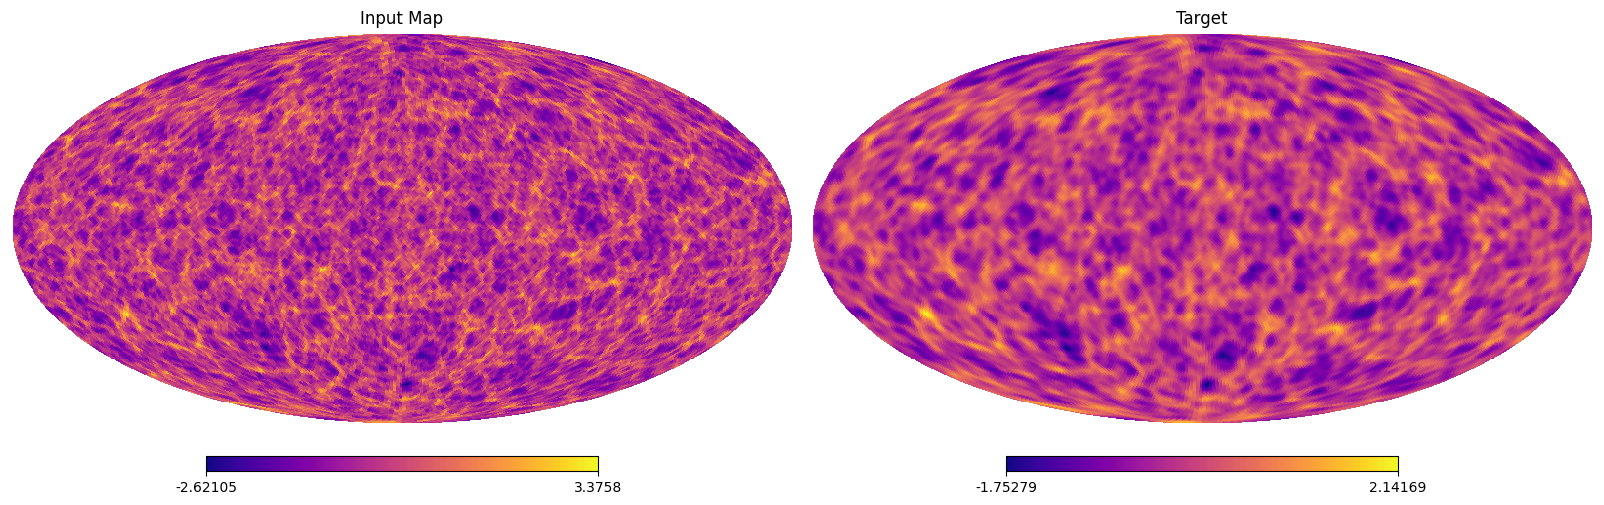

In [9]:
plt.figure(figsize=(16,6))
hp.mollview(heal_im,nest=True,hold=False,sub=(1,2,1),cmap='plasma',title='Input Map')
hp.mollview(target,nest=True,hold=False,sub=(1,2,2),cmap='plasma',title='Target')

In [10]:
u,histo = optimize_scattering_LBFGS(
        target,
        DataClass,
        SO,
        max_iter=100,
        lr=1.0,
        history_size=50,
        verbose=True,
    )

[LBFGS] inner iter 1, loss = 2.212308e-02
[LBFGS] inner iter 2, loss = 2.212249e-02
[LBFGS] inner iter 3, loss = 2.211984e-02


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(16,6))
hp.mollview(u.cpu().numpy(),nest=True,hold=False,sub=(1,2,1),cmap='plasma',title='Synthetised',min=-2,max=2)
hp.mollview(target,nest=True,hold=False,sub=(1,2,2),cmap='plasma',title='Target',min=-2,max=2)